# MR Spectroscopy with LCModel
## Analyzing MR Spectra from Rat Hippocampus

**Author**: Monika Doerig


### Citation:


#### Tools included in this workflow
__LCModel__:
- Provencher S. W. (1993). Estimation of metabolite concentrations from localized in vivo proton NMR spectra. Magnetic resonance in medicine, 30(6), 672–679. [https://doi.org/10.1002/mrm.1910300604](https://doi.org/10.1002/mrm.1910300604)
- [LCModel documentation](http://s-provencher.com/lcmodel.shtml)
- [LCModel manual](http://s-provencher.com/pub/LCModel/manual/manual.pdf)


#### Dataset
- Dunja Simicic, & Cristina Cudalbu. (2020). MR Spectra from rat hippocampus with LCModel quantification and the corresponding basis set [Data set]. In Magn Reson Med (Version Part1, Bd. 86, Nummer 5, S. 2384–2401). Zenodo. [https://doi.org/10.5281/zenodo.3904443](https://doi.org/10.5281/zenodo.3904443)

- Simicic, D., Rackayova, V., Xin, L., Tkáč, I., Borbath, T., Starcuk, Z., Jr, Starcukova, J., Lanz, B., & Cudalbu, C. (2021). In vivo macromolecule signals in rat brain 1 H-MR spectra at 9.4T: Parametrization, spline baseline estimation, and T2 relaxation times. Magnetic resonance in medicine, 86(5), 2384–2401. [https://doi.org/10.1002/mrm.28910](https://doi.org/10.1002/mrm.28910)

In [1]:
# output cpu information
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


## Load software tools and import python libraries

In [2]:
import module
await module.load('lcmodel/6.3')
await module.list()

['lcmodel/6.3']

In [3]:
%%capture 
!pip install nibabel numpy

The command below updates the package list and installs `Ghostscript`, which provides the `ps2pd`f utility for converting LCModel’s `.ps` output into a `PDF`, as well as tools to convert the `.ps` file into `PNG` images for easier inline viewing in notebooks and web pages.

In [4]:
!sudo apt update -qq && sudo apt install ghostscript -y -qq

252 packages can be upgraded. Run 'apt list --upgradable' to see them.
ghostscript is already the newest version (9.55.0~dfsg1-0ubuntu5.12).
0 upgraded, 0 newly installed, 0 to remove and 252 not upgraded.


In [5]:
# Import the necessary libraries
import matplotlib.pyplot as plt 
import os 
import subprocess
from pathlib import Path
import nibabel as nib
import numpy as np
from IPython.display import IFrame, Image, display
import re
import glob

## Get example data from the container
This section locates and verifies access to the example [dataset](https://doi.org/10.5281/zenodo.3904443) bundled inside the LCModel container. It:

- Retrieves the path to the lcmodel executable to infer the container base directory.
- Constructs full paths to the example Varian fid file and BASIS set directory located within the container.
- Uses `glob` to select the `.BASIS` file (expects exactly one).
- Verifies that the `fid` file and `.BASIS` file exist and prints their status and raises an error if any are missing.

In [6]:
# ===  Get path to lcmodel executable
lcmodel_path = subprocess.check_output("which lcmodel", shell=True, text=True).strip()

# === Extract container base and image path
container_base = os.path.dirname(lcmodel_path)  # e.g., .../lcmodel_6.3_20220222
container_id = os.path.basename(container_base)  # e.g., lcmodel_6.3_20220222
simg_path = os.path.join(container_base, f"{container_id}.simg")

# ===  Construct dataset paths inside 
fid_path = os.path.join(
    simg_path,
    "opt/datasets/Spectra_hippocampus(rat)_TE02/s_20131015_03_BDL106_scan0/isise_01.fid/fid"
)
basis_path = os.path.join(
    simg_path,
    "opt/datasets/Spectra_hippocampus(rat)_TE02/Control_files_Basis_set"
)
# Get single BASIS file (will raise error if not exactly one)
basis_files = glob.glob(os.path.join(basis_path, "*.BASIS"))
basis_file = basis_files[0]


# === Check existence of the paths
fid_exists = Path(fid_path).exists()
basis_dir_exists = Path(basis_path).exists()
basis_file_exists = Path(basis_file).exists()

# === Report status
print(f"FID path:          {fid_path}")
print(f"BASIS file:        {basis_file}")
print(f"FID exists?        {'✅' if fid_exists else '❌'}")
print(f"BASIS dir exists?  {'✅' if basis_dir_exists else '❌'}")
print(f"BASIS file exists?  {'✅' if basis_file_exists else '❌'}")

# Raise error or fallback if paths missing
if not fid_exists or not basis_file_exists:
    raise FileNotFoundError("One or more required dataset paths could not be found.")

FID path:          /cvmfs/neurodesk.ardc.edu.au/containers/lcmodel_6.3_20220222/lcmodel_6.3_20220222.simg/opt/datasets/Spectra_hippocampus(rat)_TE02/s_20131015_03_BDL106_scan0/isise_01.fid/fid
BASIS file:        /cvmfs/neurodesk.ardc.edu.au/containers/lcmodel_6.3_20220222/lcmodel_6.3_20220222.simg/opt/datasets/Spectra_hippocampus(rat)_TE02/Control_files_Basis_set/9T_TE02_smallTMS_simulated-apoL0,2Hz-apoG1,8Hz_MM-ourMM_newGrad750_allRemoved.BASIS
FID exists?        ✅
BASIS dir exists?  ✅
BASIS file exists?  ✅


## Set up LCModel configuration files
This script sets up the LCModel environment by copying the hidden `.lcmodel` directory (containing all required binaries and configuration files) into your home folder. If the `.lcmodel` directory already exists, the script normally prompts whether to overwrite it — however, in a notebook environment, this prompt is not interactive. To avoid errors, the script can be conditionally run only if `.lcmodel` does not already exist.

In [7]:
if not os.path.exists(os.path.expanduser("~/.lcmodel")):
    !setup_lcmodel.sh
else:
    print("~/.lcmodel already exists — skipping setup.")

~/.lcmodel already exists — skipping setup.


## Convert Varian fid file to LCModel-compatible .RAW
This step uses the `bin2raw` utility to convert the Varian fid file and its associated procpar file into a `.RAW` file that LCModel can process.
In addition to the `.RAW` file, two auxiliary files are also generated: `cpStart` and `extraInfo`. These are typically used by LCMgui to autofill settings, but in this notebook-based workflow, we'll manually extract relevant information from `extraInfo` and `.RAW` to generate a custom control (.CONTROL) file for LCModel.

**Details & Requirements for bin2raw:**

The input data must be named fid, and the corresponding procpar file must be in the same directory.

`bin2raw` assumes a voxel volume of 1.0, so water-scaling will only be accurate if the suppressed and unsuppressed water scans were acquired with identical voxel sizes.

The script depends on `bin2asc`, which must be located in ~/.lcmodel/varian/. First, let's check if the files are there:

In [8]:
! ls /home/jovyan/.lcmodel/varian

bin2asc  bin2raw  preprocessors


Run `bin2raw` to convert the Varian fid file into an LCModel `.RAW` file. The output is saved in a subdirectory (./lcmodel_outputs/raw/) that is visible in JupyterLab for inspection and further use.

In [9]:
%%bash -s "$fid_path"
DATA_FILE="$1"
LCM_DIR="./lcmodel_outputs/"
MET_H2O="raw"

mkdir -p "${LCM_DIR}${MET_H2O}"
    
/home/jovyan/.lcmodel/varian/bin2raw $DATA_FILE $LCM_DIR $MET_H2O

### Visualizing the RAW FID data from the RAW file

The following code loads and visualizes the raw time-domain data from the .RAW file. This file contains the input data for a single rat from the Simicic and Cudalbu (2020) dataset.
According to the study's methods, the data was acquired using a single-voxel SPECIAL sequence in the rat hippocampus (TE=2.8ms, TR=4s). The full experiment involved collecting 160 individual acquisitions (transients) to ensure a high signal-to-noise ratio.
Our plot visualizes a subset of this data. As we will confirm in the next step when we extract the acquisition parameters, the file contains the first 10 of these transients, each composed of 4096 complex data points. Each large spike in the plot marks the beginning of one of these 10 transients. 

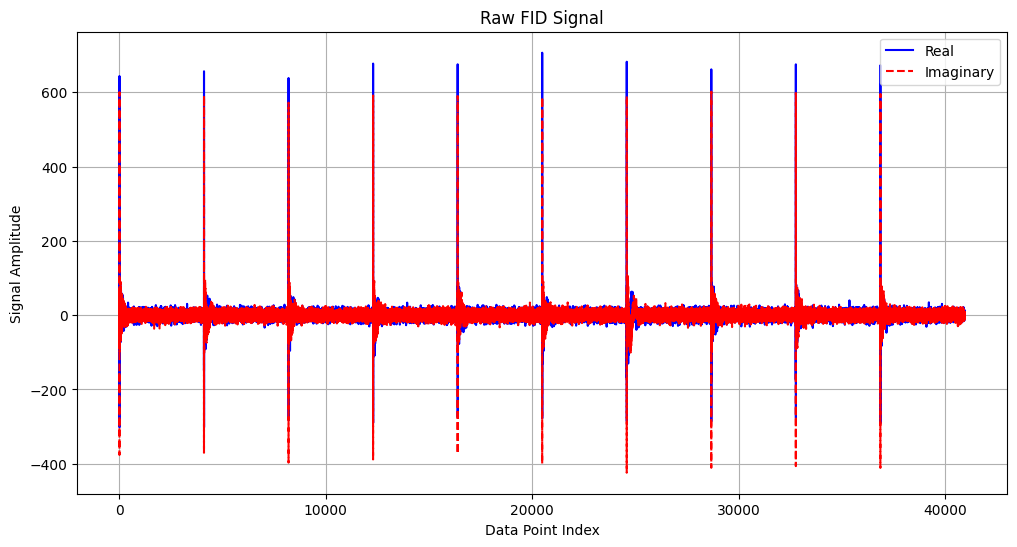

In [57]:
# Load data from RAW for plotting
def load_raw_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Skip past the two header blocks
    end_count = 0
    data_start = 0
    for i, line in enumerate(lines):
        if line.strip() == '$END':
            end_count += 1
            if end_count == 2:
                data_start = i + 1
                break

    data_vals = []
    for line in lines[data_start:]:
        parts = line.strip().split()
        if len(parts) == 2:
            data_vals.extend([float(x) for x in parts])

    real = np.array(data_vals[0::2])
    imag = np.array(data_vals[1::2])
    return real, imag

real, imag = load_raw_data("./lcmodel_outputs/raw/RAW")

# Create the x-axis using the number of points
data_points = np.arange(len(real))

#  Plot the data
plt.figure(figsize=(12, 6))

plt.plot(data_points, real, label='Real', color='blue')
plt.plot(data_points, imag, label='Imaginary', color='red', linestyle='--')

plt.title("Raw FID Signal")
plt.xlabel("Data Point Index")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.grid(True)
plt.show()

## Extracting parameters to generate the control file 

As noted earlier, the `bin2raw` conversion produces auxiliary files such as `cpStart` and embeds a `$SEQPAR` block in the `.RAW` file. These contain key acquisition and sequence parameters needed to generate the LCModel control file. In this step, we extract those parameters by parsing both `cpStart` and the `$SEQPAR` block from the `RAW` file. The parsed values are merged into a single dictionary, with `$SEQPAR` values overriding `cpStart` in case of overlap. This consolidated parameter set will be used to programmatically construct the `.CONTROL` file for LCModel.

In [12]:
def parse_cpstart_file(filepath):
    params = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or '=' not in line:
                continue
            key, val = line.split('=', 1)
            key = key.strip()
            val = val.strip().strip("'")
            try:
                if '.' in val or 'e' in val.lower():
                    val = float(val)
                else:
                    val = int(val)
            except ValueError:
                pass
            params[key] = val
    return params

def parse_raw_seqpar(filepath):
    params = {}
    seqpar_block = False
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('$SEQPAR'):
                seqpar_block = True
                continue
            if line.startswith('$END') and seqpar_block:
                break
            if seqpar_block:
                # example line: hzpppm=400.268
                if '=' in line:
                    key, val = line.split('=', 1)
                    key = key.strip()
                    val = val.strip()
                    try:
                        if '.' in val or 'e' in val.lower():
                            val = float(val)
                        else:
                            val = int(val)
                    except ValueError:
                        val = val.strip("'")
                    params[key] = val
    return params

# Paths to cpStart and RAW
cpstart_path = "./lcmodel_outputs/raw/cpStart"
raw_path = "./lcmodel_outputs/raw/RAW"  

# Parse both
cpstart_params = parse_cpstart_file(cpstart_path)
seqpar_params = parse_raw_seqpar(raw_path)

# Merge dictionaries, seqpar overrides cpstart if keys overlap
all_params = {**cpstart_params, **seqpar_params}
print(all_params)

{'title': 's_20131015_03  (2013/10/15 22:28:27)  isise  TE/TR/NS=3/4000/16', 'filraw': './lcmodel_outputs/raw/RAW', 'filps': './lcmodel_outputs/ps', 'hzpppm': 400.268, 'deltat': 0.0002, 'nunfil': 4096, 'ndcols': 1, 'ndrows': 10, 'ndslic': 1, 'echot': 3.0}


###  Write and run the control file
With all required acquisition parameters parsed from the `.RAW` and `cpStart` files, we now generate the LCModel control file programmatically. This file defines the input data (.RAW), output locations (e.g., .TABLE, .PS, .CSV, .COORD), basis set, and sequence-specific parameters such as spectral width or echo time. The control file is written to disk using the `write_lcmodel_control()` function. Finally, LCModel is executed by piping the control file into the lcmodel command-line tool, launching the spectral fitting and quantification process.

**Note:** LCModel is now free software. To use it, the **key = 210387309** needs to be included in the LCModel control file ([http://s-provencher.com/lcmodel.shtml](http://s-provencher.com/lcmodel.shtml)).

In [13]:
# File paths
res_dir = "./lcmodel_outputs/results"
os.makedirs(res_dir, exist_ok=True)

table_path = os.path.join(res_dir, "table")
csv_path = os.path.join(res_dir, "csv")
coord_path = os.path.join(res_dir,"coord")
ps_path = os.path.join(res_dir,"ps")

In [14]:
def write_lcmodel_control(control_path,
                          raw_path,
                          srcraw,
                          basis_path,
                          ps_path,
                          table_path,
                          csv_path,
                          coord_path,
                          title,
                          nunfil,
                          ndslic,
                          ndrows,
                          ndcols,
                          hzpppm,
                          echot,
                          deltat,
                          irowst,
                          irowen,
                          icolst,
                          icolen,
                          ppmst=4.0,
                          ppmend=0.2,
                          ltable=7,
                          lps=8,
                          lcsv=11,
                          lcoord=9,
                          islice=1,
                          key=210387309
                         ):
    """
    Writes a formatted control file for an LCModel analysis.

    This function generates the .CONTROL file that LCModel uses as its primary
    input, specifying all file paths, acquisition parameters, and analysis options.
    
    Parameters:
        Required:
            control_path (str): Output path for the CONTROL file
            raw_path (str): Path to the .RAW file that LCModel will analyze
            srcraw (str): Path to original FID file (for reference)
            basis_path (str): Path to BASIS file containing the metabolite basis spectra
            ps_path (str): Output path for PS file
            table_path (str): Output path for TABLE file
            csv_path (str): Output path for CSV file
            coord_path (str): Output path for COORD file
            title (str): Title of the scan
            nunfil (int):  Number of complex data points per FID transient
            ndslic (int): Number of slices in the data (usually 1 for Single Voxel Spectroscopy)
            ndrows (int): Number of rows (transients) in the .RAW file.
            ndcols (int): Number of columns (usually 1 for SVS)
            hzpppm (float): Spectrometer frequency (MHz)
            echot (float): Echo time (TE) in ms
            deltat (float): Time between points (dwell time) in seconds
            irowst (int), irowen (int): Start/end row for analysis
            icolst (int), icolen (int): Start/end column for analysis

        Optional:
            ppmst (float): Upper limit of ppm window (default: 4.0)
            ppmend (float): Lower limit of ppm window (default: 0.2)
            islice (int): Slice to analyze (default: 1)
            ltable (int), lps (int), lcsv (int), lcoord (int): Output switches to generate output files
            islice (int): Slice to analyze (default: 1)
            key (int): Free License key (hard coded)
    """
    content = f""" $LCMODL
 title= '{title}'
 srcraw= '{srcraw}'
 ppmst= {ppmst}
 ppmend= {ppmend}
 nunfil= {nunfil}
 ndslic= {ndslic}
 ndrows= {ndrows}
 ndcols= {ndcols}
 ltable= {ltable}
 lps= {lps}
 islice= {islice}
 irowst= {irowst}
 irowen= {irowen}
 icolst= {icolst}
 icolen= {icolen}
 hzpppm= {hzpppm}
 filtab= '{table_path}'
 filraw= '{raw_path}'
 filps= '{ps_path}'
 filbas= '{basis_path}'
 echot= {echot}
 deltat= {deltat}
 key= {key}
 lcsv= {lcsv}
 filcsv= '{csv_path}'
 lcoord= {lcoord}
 filcoo= '{coord_path}'
 $END
"""
    with open(control_path, "w", encoding="ascii") as f:
        f.write(content)
    print(f"✅ CONTROL file written to {control_path}")


In [15]:
write_lcmodel_control(
    control_path='./lcmodel_outputs/control',
    raw_path=raw_path,
    srcraw=fid_path,
    basis_path=basis_file,  
    ps_path=ps_path,
    table_path=table_path,   
    csv_path=csv_path,       
    coord_path=coord_path,   
    title=all_params.get('title', 'Default Title'),
    ppmst=4.0, # Left edge of ppm window
    ppmend=0.2, # Right edge of ppm window
    nunfil=all_params['nunfil'],
    ndslic=all_params['ndslic'],
    ndrows=all_params['ndrows'],
    ndcols=all_params['ndcols'],
    ltable=7, #will create filtab
    lps=8, #will create filps
    #key=210387309,#
    irowst=1, #default - selecting row 1 through irowen for preview and analysis
    irowen=all_params['ndrows'],
    icolst=1, #default - selecting columns 1 through icolen for preview an analysis
    icolen=all_params['ndcols'],
    hzpppm=all_params['hzpppm'],
    echot=all_params['echot'],  
    deltat=all_params['deltat'],
    lcsv=11, # will make filcsv
    lcoord=9, # will make filcoo
)

✅ CONTROL file written to ./lcmodel_outputs/control


In [16]:
!lcmodel < ./lcmodel_outputs/control

## Conversion to PDF and PNG formats
LCModel outputs a PostScript `(.ps`) file summarizing the spectral fit results, which can be converted to other formats like `PDF` or to `PNG` images for easier viewing and sharing. Converting to PDF using `ps2pdf` preserves the vector graphics and multipage layout, making it suitable for high-quality printing and detailed inspection. 
Alternatively, converting the .ps to PNG images with Ghostscript produces raster images (one per page) that are easy to display inline in notebooks and web pages without requiring PDF viewers.

In [17]:
#convert .ps to .pdf
!ps2pdf ./lcmodel_outputs/results/sl1_1-1.ps ./lcmodel_outputs/results/sl1_1-1.pdf

In [52]:
#convert .ps to 2 png images 
!gs -dSAFER -dBATCH -dNOPAUSE -dAutoRotatePages=/None \
    -sDEVICE=png16m -r200 \
    -dFirstPage=1 \
    -sOutputFile=./lcmodel_outputs/results/sl1_1-1_page_%d.png \
    -c "<</Orientation 1>> setpagedevice" \
    -f ./lcmodel_outputs/results/sl1_1-1.ps

GPL Ghostscript 9.55.0 (2021-09-27)
Copyright (C) 2021 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Loading NimbusSans-Regular font from /usr/share/ghostscript/9.55.0/Resource/Font/NimbusSans-Regular... 4466276 2919877 1781504 467336 1 done.
Loading NimbusSans-Italic font from /usr/share/ghostscript/9.55.0/Resource/Font/NimbusSans-Italic... 4532388 3109138 1801704 480027 1 done.
Loading NimbusMonoPS-Bold font from /usr/share/ghostscript/9.55.0/Resource/Font/NimbusMonoPS-Bold... 4719700 3356954 1882504 536121 1 done.
Loading NimbusMonoPS-Regular font from /usr/share/ghostscript/9.55.0/Resource/Font/NimbusMonoPS-Regular... 4967612 3596746 1882504 539928 1 done.


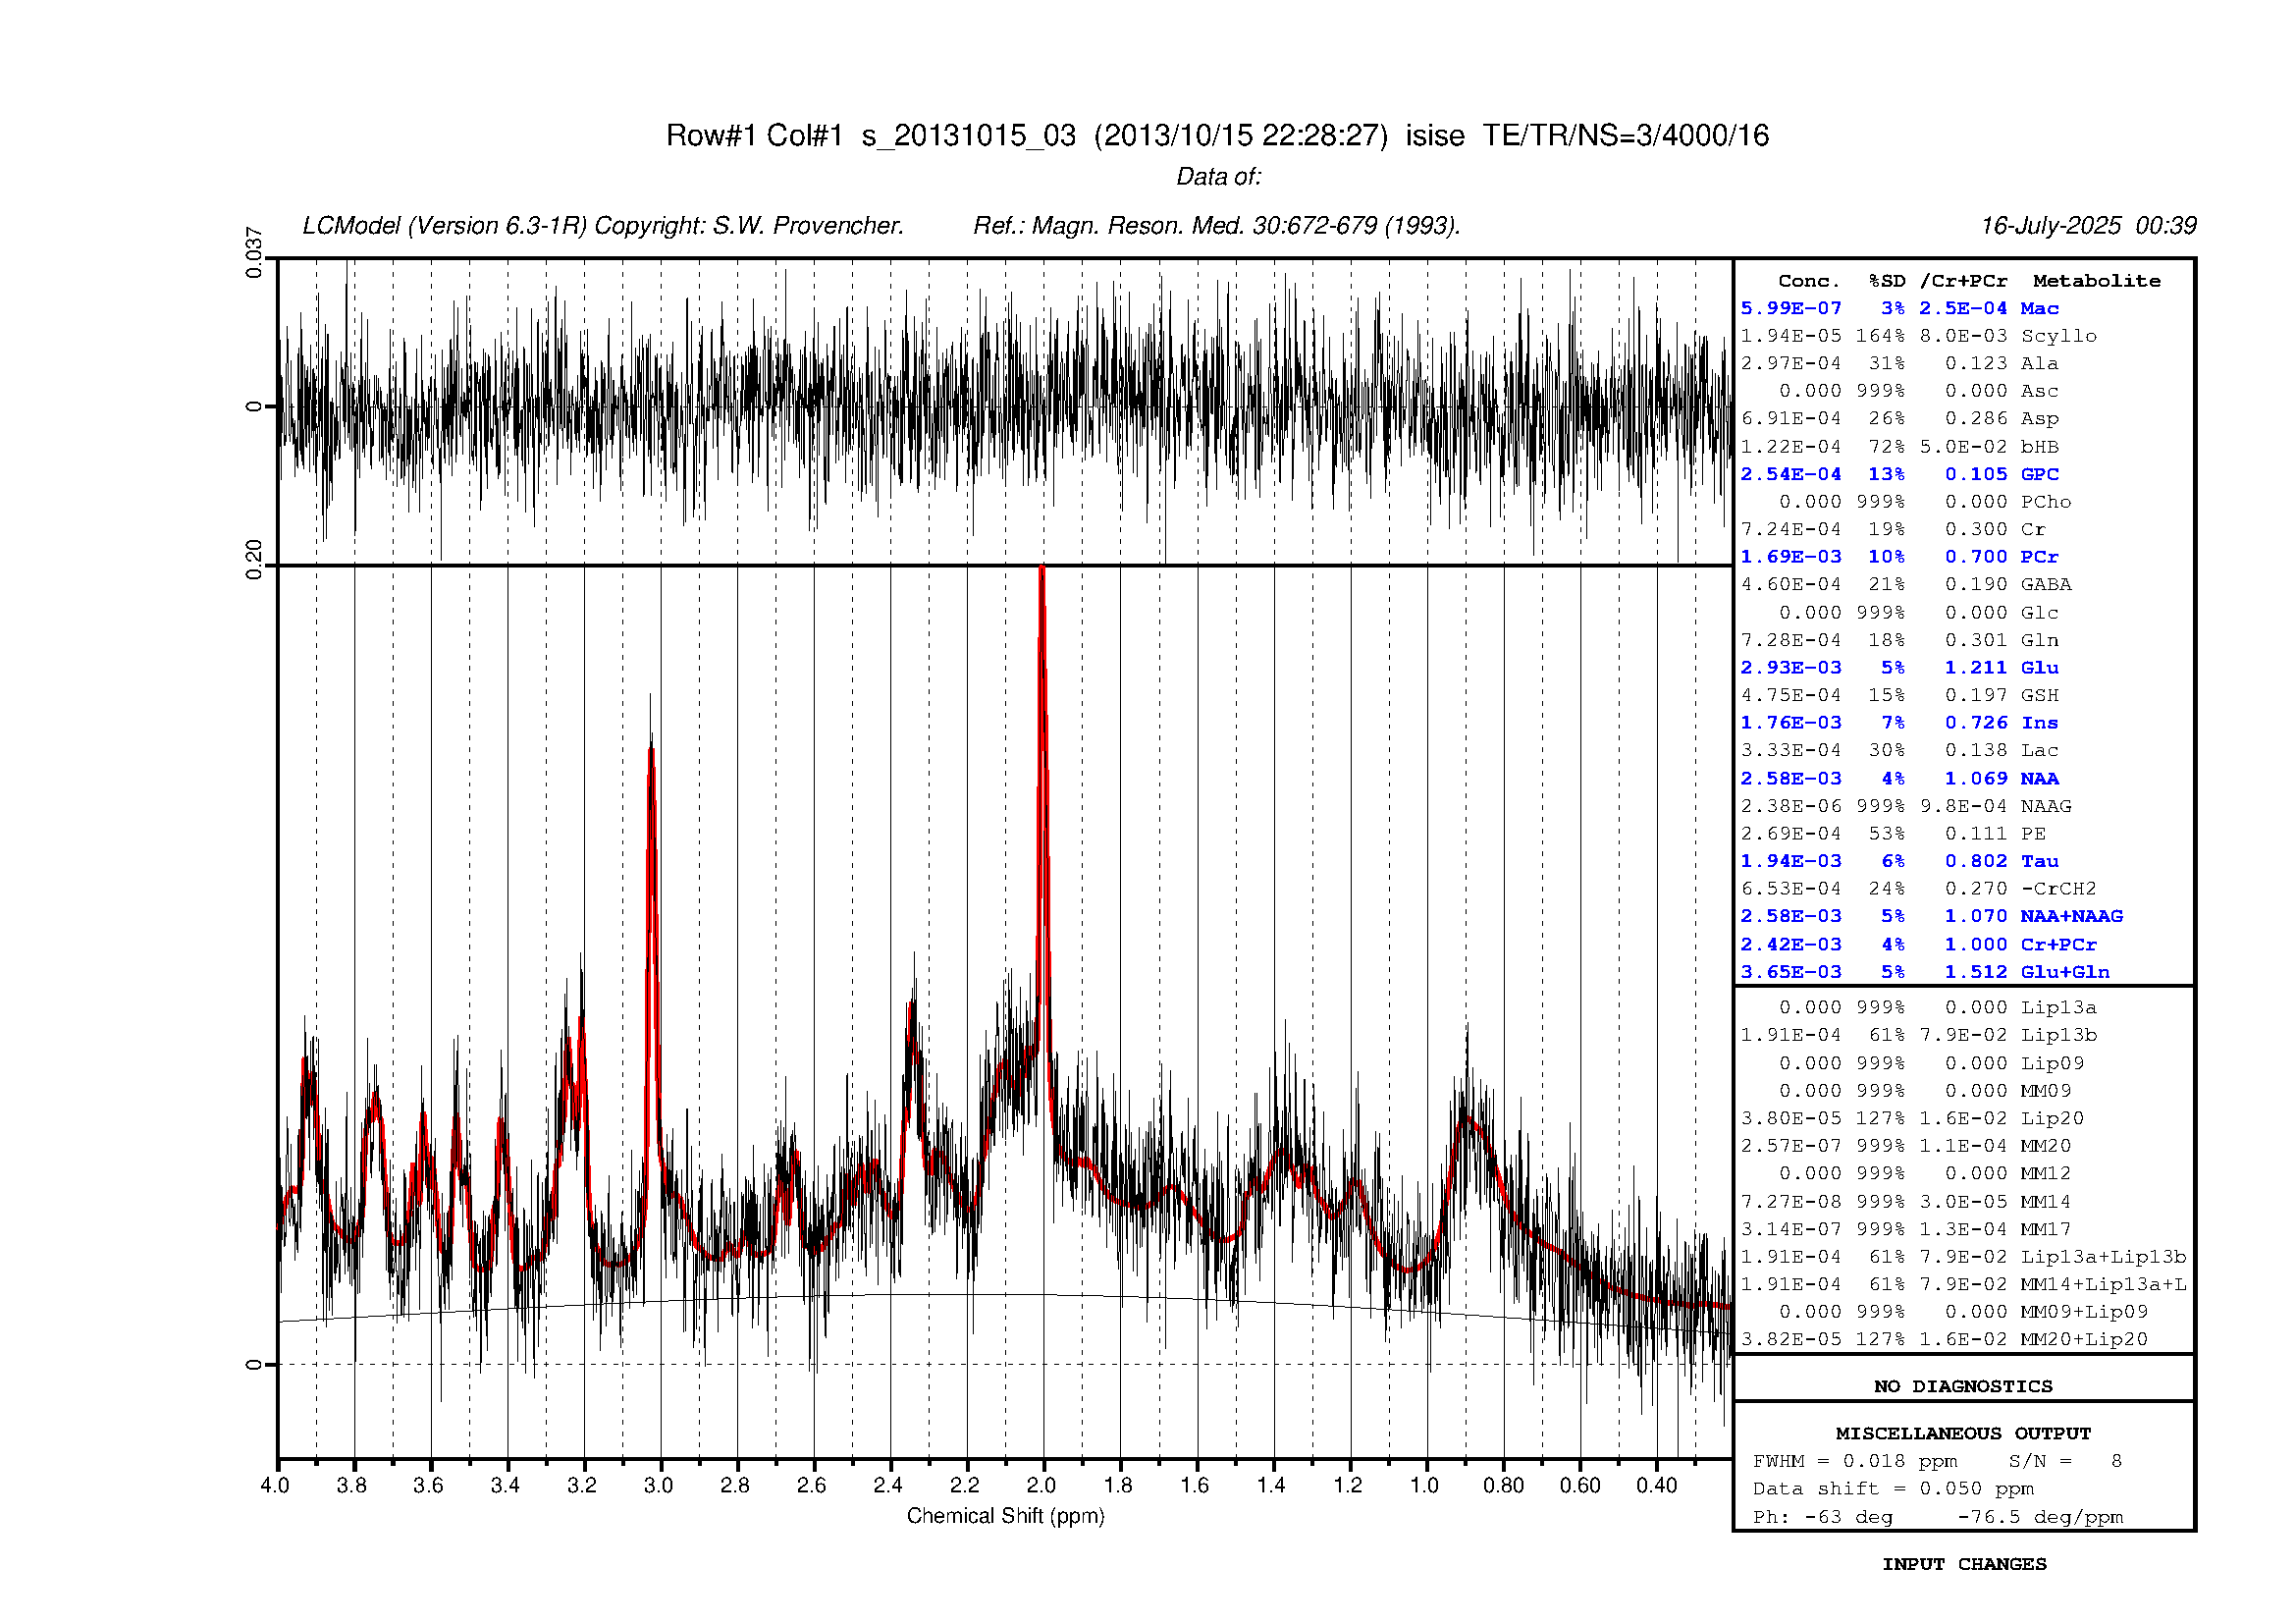

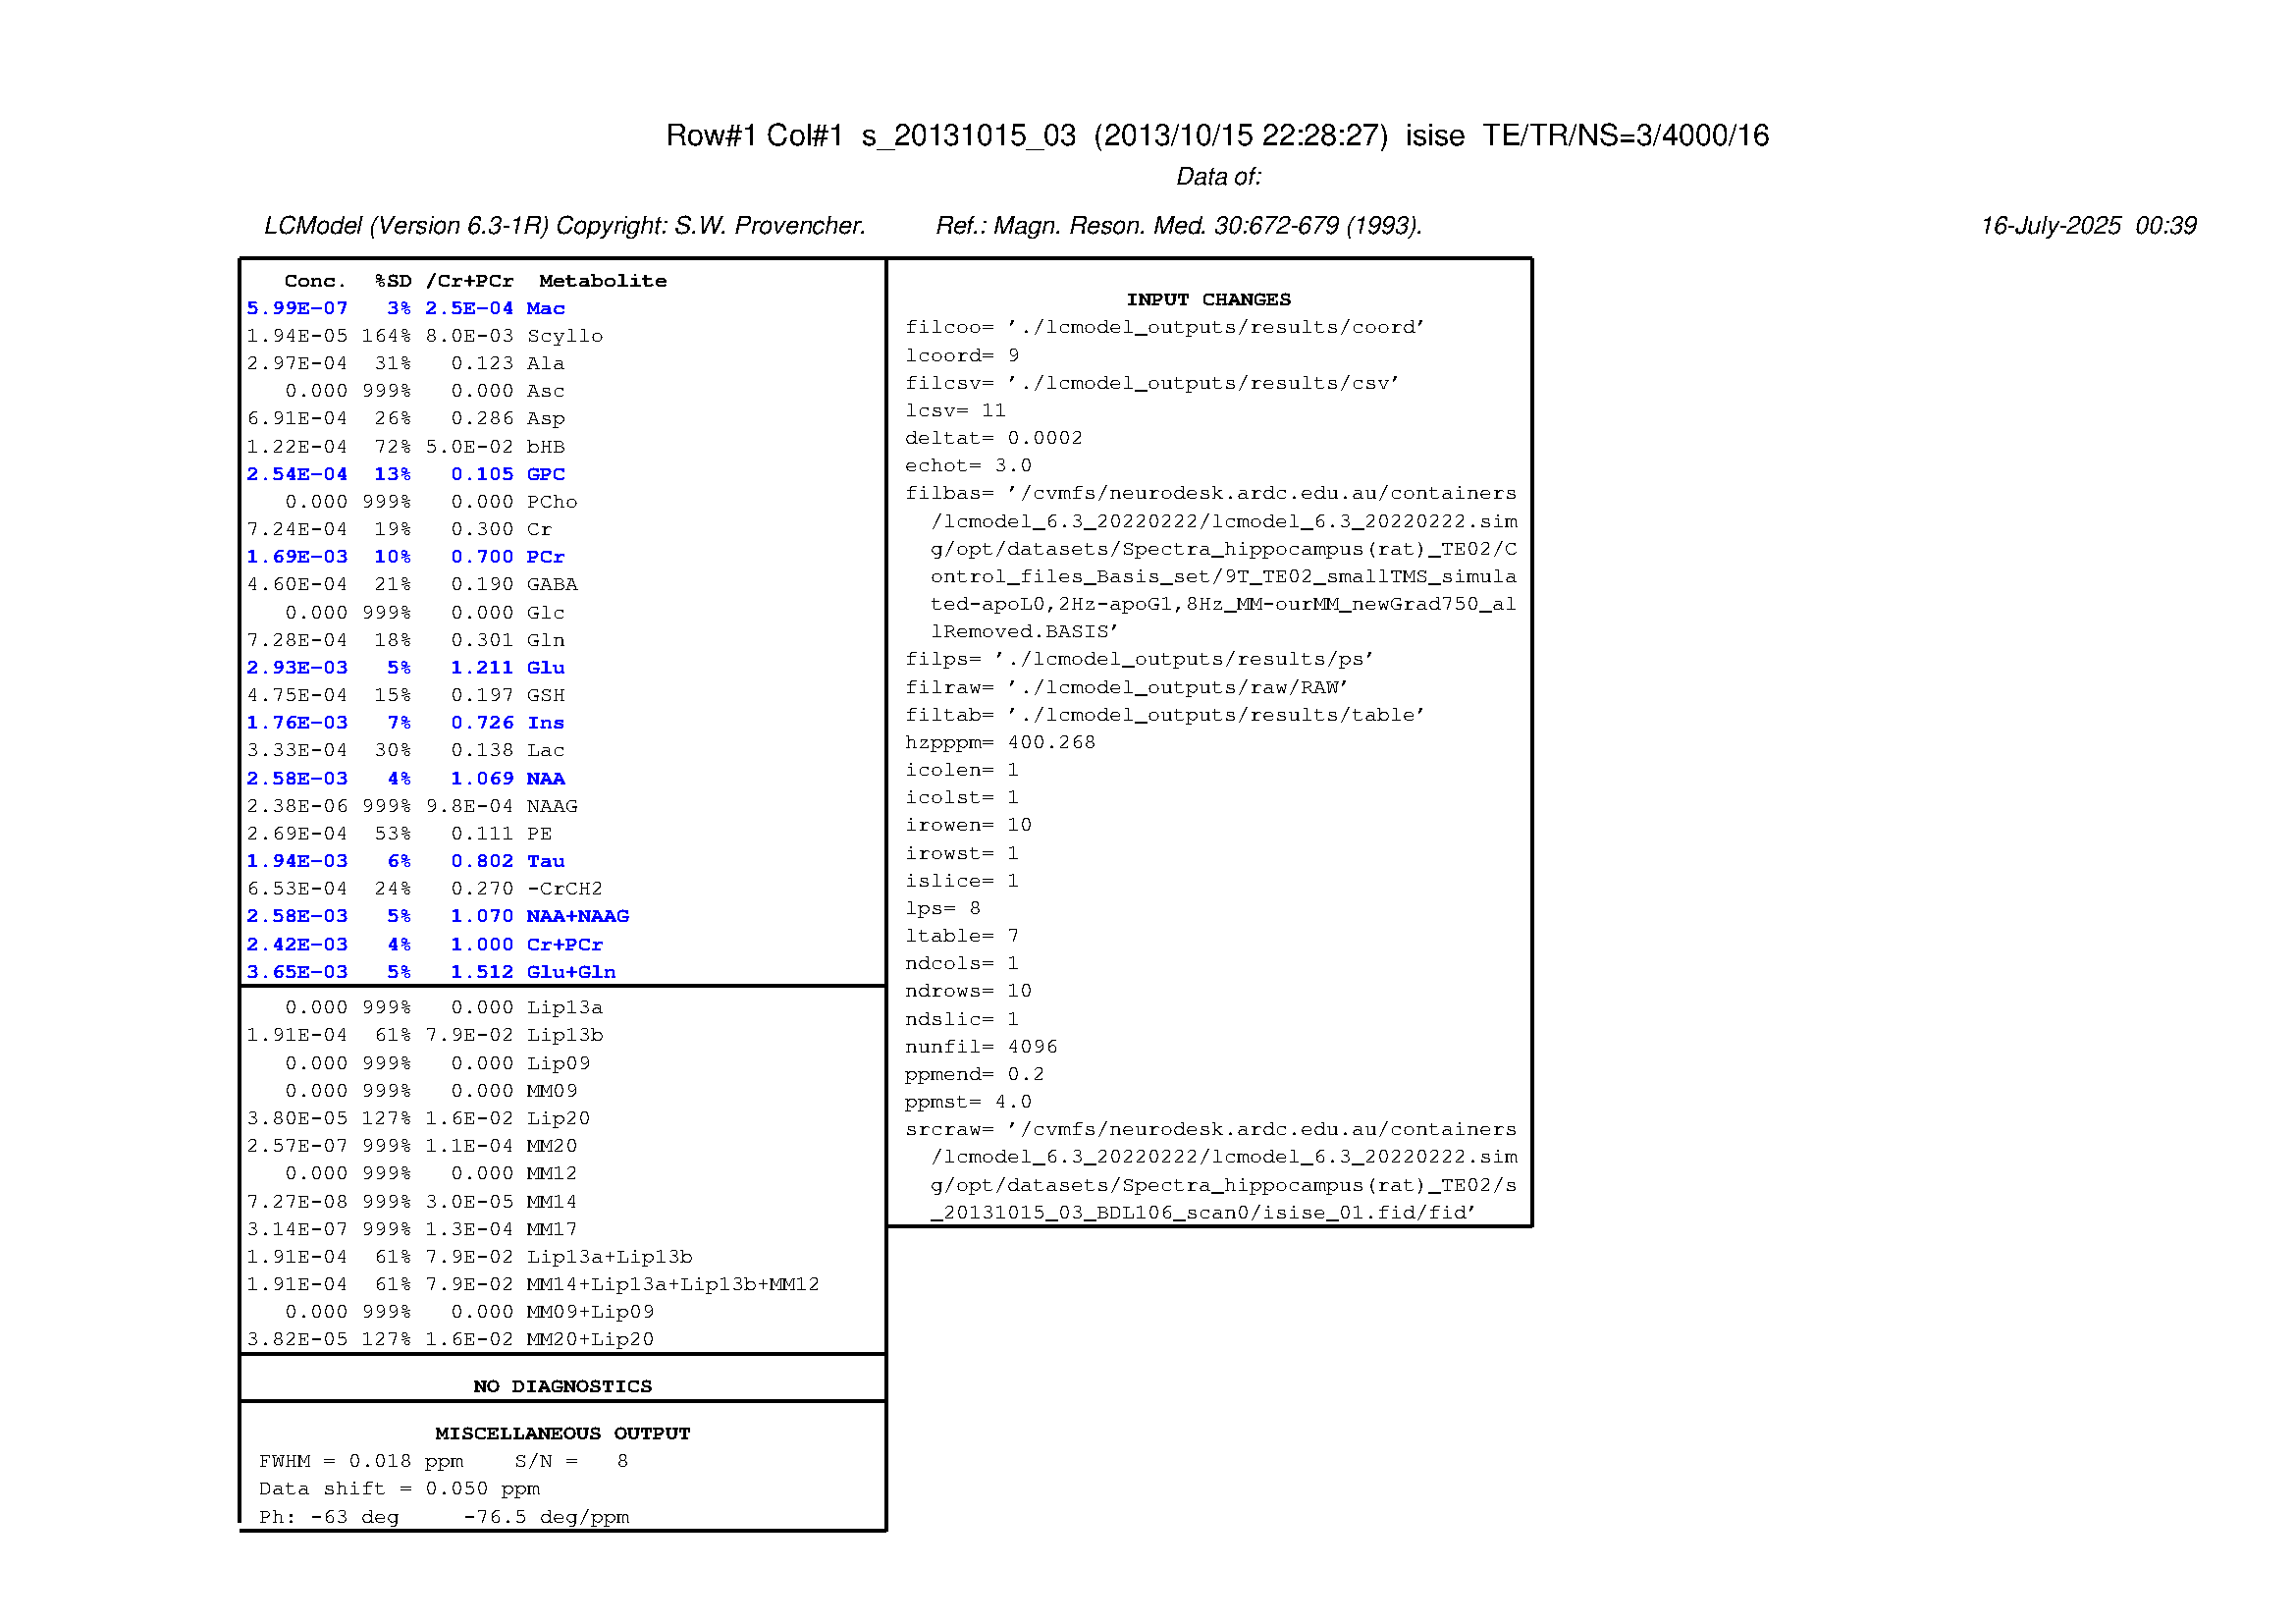

In [54]:
# displayt the to png images (two pdf pages)
for i in range(1, 2 + 1): 
    display(Image(filename=f"./lcmodel_outputs/results/sl1_1-1_page_{i}.png"))

Within the notebook, PDFs can also be displayed with `IFrame`:
    
```python
IFrame("./lcmodel_outputs/results/sl1_1-1.pdf", width=1000, height=800)
```